In [1]:
import os
import soundfile as sf           
import numpy as np               
import matplotlib.pyplot as plt  
from scipy.signal import welch   
from scipy.io import wavfile
import scipy.signal as sps
import librosa
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import math

from sampling import module_functions
from convolving import module_functions_conv
from IPython.display import Audio
from IPython import display

import torch.nn as nn
import torchvision
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as Fu
import sounddevice as sd

In [2]:
_SAMPLE_DIR_AUD  = "audio_data"

audio_path = os.path.join(_SAMPLE_DIR_AUD, "sandy-beach8k.wav")
os.makedirs(_SAMPLE_DIR_AUD, exist_ok=True)

audio_path_rev = os.path.join(_SAMPLE_DIR_AUD, "reverberant_room8k.wav")
os.makedirs(_SAMPLE_DIR_AUD, exist_ok=True)

# Operación de Convolución de audio

In [3]:
audio1, sample_rate = torchaudio.load(audio_path)

In [4]:
Audio(audio1.numpy()[0], rate=sample_rate)

In [5]:
print(sample_rate)

8000


In [6]:
audio2, sample_rate2 = torchaudio.load(audio_path_rev)

In [7]:
Audio(audio2.numpy()[0], rate=sample_rate2)

In [8]:
print(sample_rate2)

8000


In [9]:
module_functions_conv.print_stats(audio1, sample_rate=sample_rate)

Sample Rate: 8000
Shape: (1, 142571)
Dtype: torch.float32
 - Max:      0.366
 - Min:     -0.362
 - Mean:     0.000
 - Std Dev:  0.036

tensor([[-0.0025, -0.0037, -0.0026,  ..., -0.0009, -0.0045, -0.0077]])



In [10]:
module_functions_conv.print_stats(audio2, sample_rate=sample_rate)

Sample Rate: 8000
Shape: (1, 23791)
Dtype: torch.float32
 - Max:      0.275
 - Min:     -0.259
 - Mean:    -0.000
 - Std Dev:  0.031

tensor([[-0.0462, -0.1097, -0.0220,  ..., -0.0028, -0.0038, -0.0027]])



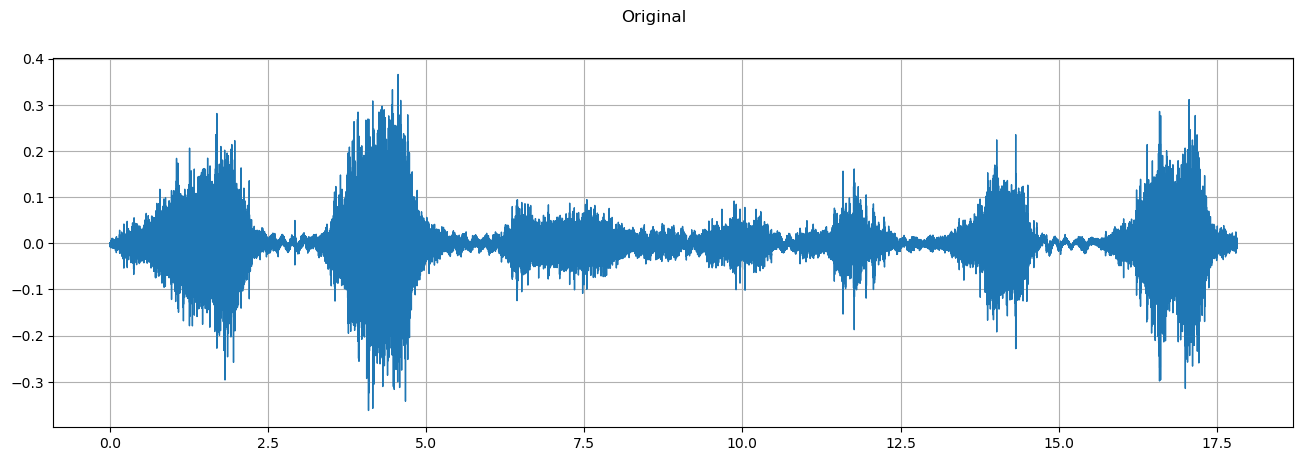

In [11]:
module_functions_conv.plot_waveform(audio1, sample_rate, title="Original")

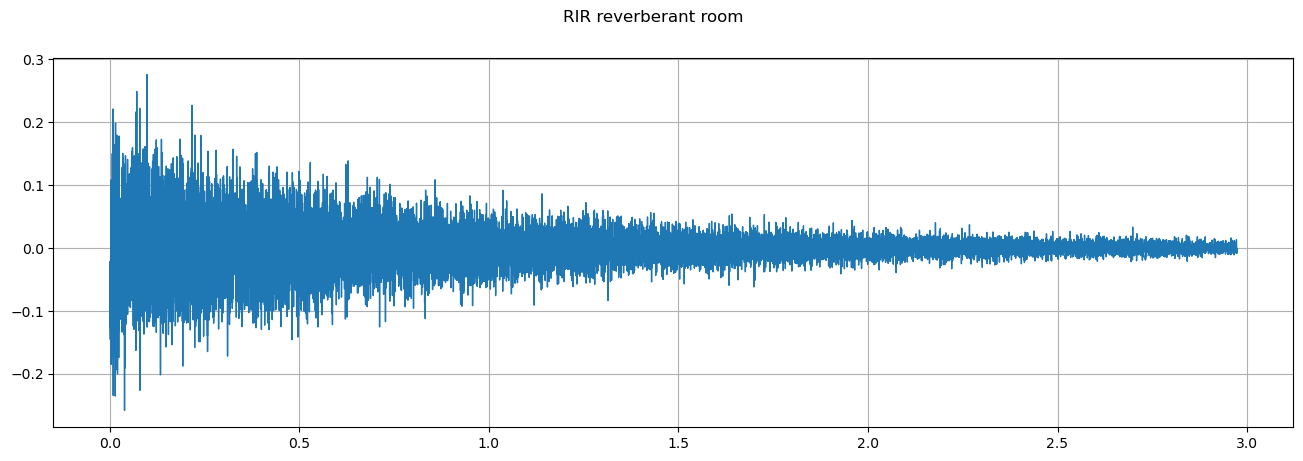

In [12]:
module_functions_conv.plot_waveform(audio2, sample_rate, title="RIR reverberant room")

In [13]:
print(audio1.shape)

torch.Size([1, 142571])


In [14]:
print(audio1.shape[1])

142571


In [15]:
print(audio2.shape)

torch.Size([1, 23791])


In [16]:
print(audio2.shape[1])

23791


In [17]:
audio2n = audio2.numpy()
audio2n

array([[-0.04620361, -0.10968018, -0.02197266, ..., -0.00283813,
        -0.00384521, -0.00274658]], dtype=float32)

In [18]:
print(audio2n[0].shape[0])


23791


In [19]:
print(audio2n[0:audio1.shape[1]]-1)

[[-1.0462036 -1.1096802 -1.0219727 ... -1.0028381 -1.0038452 -1.0027466]]


In [20]:
audio_1 = torch.nn.functional.pad(audio1, (audio2.shape[1]-1, 0))
audio3 = torch.nn.functional.conv1d(audio_1[None, ...], audio2[None, ...])[0]

In [21]:
Audio(audio3.numpy()[0], rate=sample_rate)

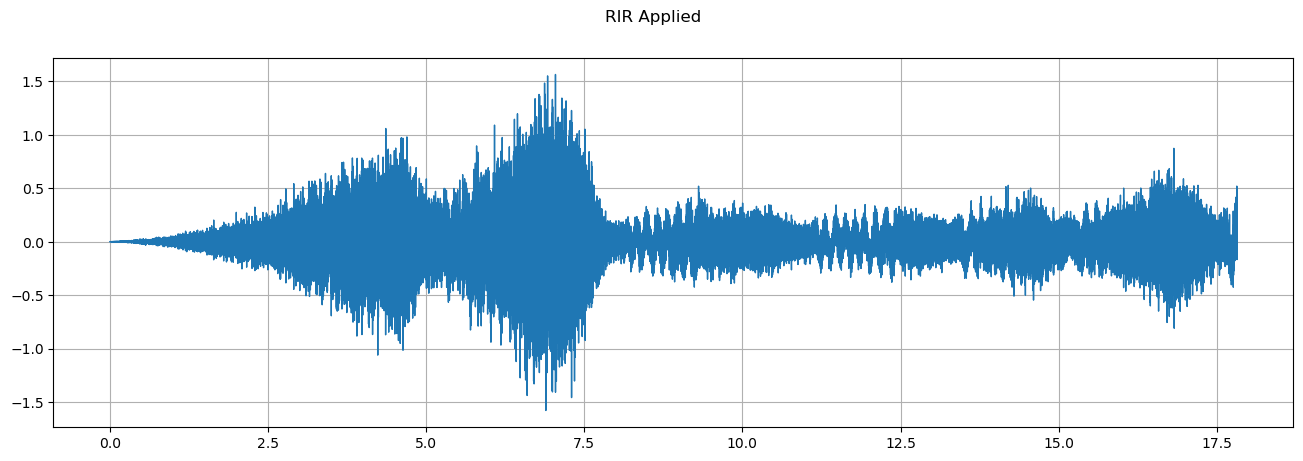

In [22]:
module_functions_conv.plot_waveform(audio3, sample_rate, title="RIR Applied")

In [23]:
noise, _ = module_functions_conv.get_noise_sample(resample=sample_rate)
Audio(noise.numpy()[0], rate=sample_rate)

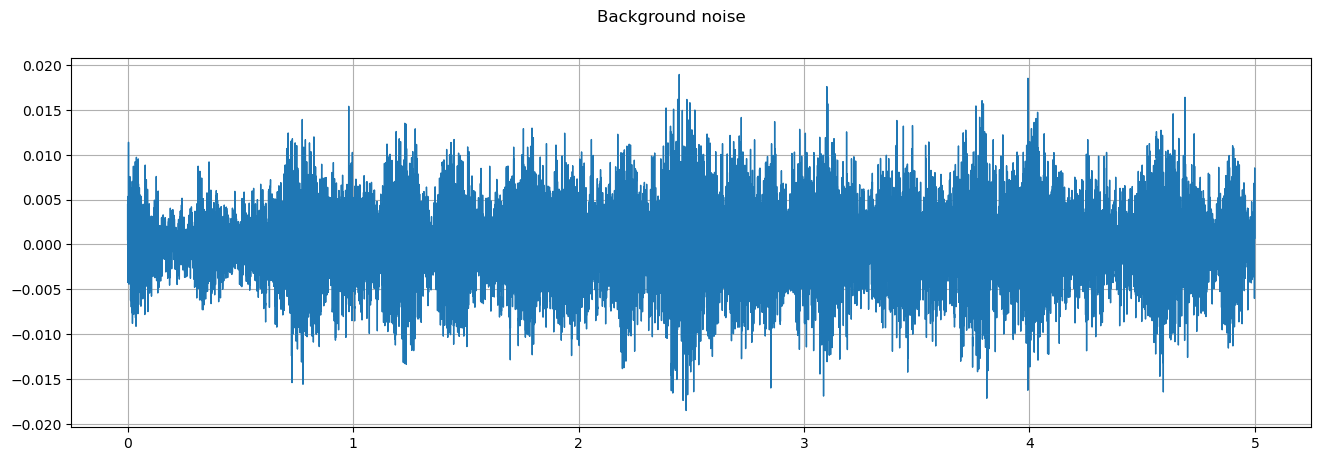

In [24]:
noise = noise[:, :audio1.shape[1]]
module_functions_conv.plot_waveform(noise, sample_rate, title="Background noise")

In [25]:
audio1_power = audio1.norm(p=2)
noise_power = noise.norm(p=2)

In [26]:
audio11 = audio1.numpy()
audio12 = audio11[0]
audio12[0:160000]

array([-0.00250244, -0.00366211, -0.00262451, ..., -0.00094604,
       -0.00454712, -0.00765991], dtype=float32)

In [27]:
print(len(audio12[0:160000]))

142571


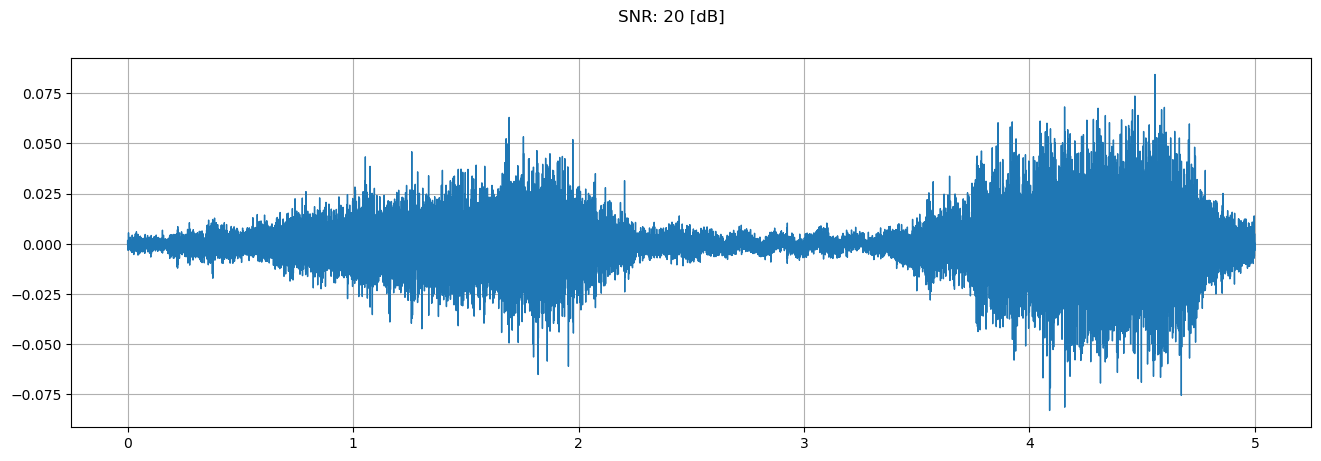

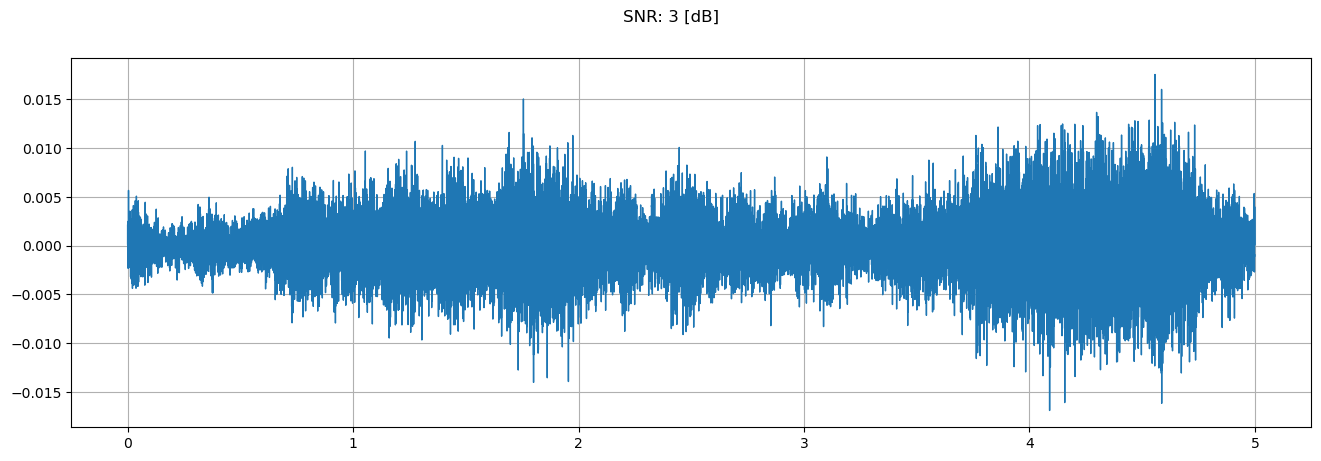

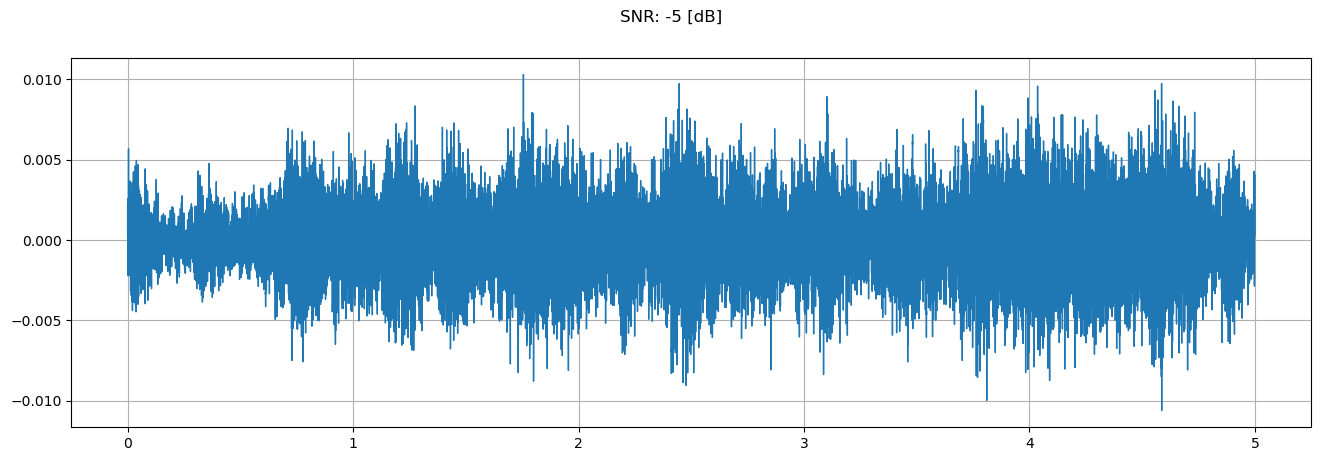

In [28]:
for snr_db in [20, 3, -5]:
    snr = math.exp(snr_db / 10)
    scale = snr * noise_power / audio1_power
    noisy_audio1 = (scale * audio12[0:40000] + noise) / 2

    module_functions_conv.plot_waveform(noisy_audio1, sample_rate, title=f"SNR: {snr_db} [dB]")
    module_functions_conv.play_audio(noisy_audio1, sample_rate)